ข้อมูลทั้งหมด: (12575, 11)
  Transaction ID Customer ID       Category          Item  Price Per Unit  \
0    TXN_6867343     CUST_09     Patisserie   Item_10_PAT            18.5   
1    TXN_3731986     CUST_22  Milk Products  Item_17_MILK            29.0   
2    TXN_9303719     CUST_02       Butchers   Item_12_BUT            21.5   
3    TXN_9458126     CUST_06      Beverages   Item_16_BEV            27.5   
4    TXN_4575373     CUST_05           Food   Item_6_FOOD            12.5   

   Quantity  Total Spent  Payment Method Location Transaction Date  \
0      10.0        185.0  Digital Wallet   Online       2024-04-08   
1       9.0        261.0  Digital Wallet   Online       2023-07-23   
2       2.0         43.0     Credit Card   Online       2022-10-05   
3       9.0        247.5     Credit Card   Online       2022-05-07   
4       7.0         87.5  Digital Wallet   Online       2022-10-02   

  Discount Applied  
0             True  
1             True  
2            False  
3    

         MAE  MSE    RMSE   R2   RMSLE    MAPE
Fold                                          
0     0.0005  0.0  0.0058  1.0  0.0011  0.0001
1     0.0003  0.0  0.0024  1.0  0.0003  0.0000
2     0.0004  0.0  0.0023  1.0  0.0003  0.0001
3     0.0011  0.0  0.0069  1.0  0.0007  0.0001
4     0.0004  0.0  0.0031  1.0  0.0003  0.0000
5     0.0007  0.0  0.0040  1.0  0.0006  0.0001
6     0.0003  0.0  0.0025  1.0  0.0004  0.0000
7     0.0003  0.0  0.0024  1.0  0.0003  0.0000
8     0.0005  0.0  0.0038  1.0  0.0006  0.0001
9     0.0005  0.0  0.0028  1.0  0.0004  0.0001
Mean  0.0005  0.0  0.0036  1.0  0.0005  0.0001
Std   0.0002  0.0  0.0015  0.0  0.0002  0.0000


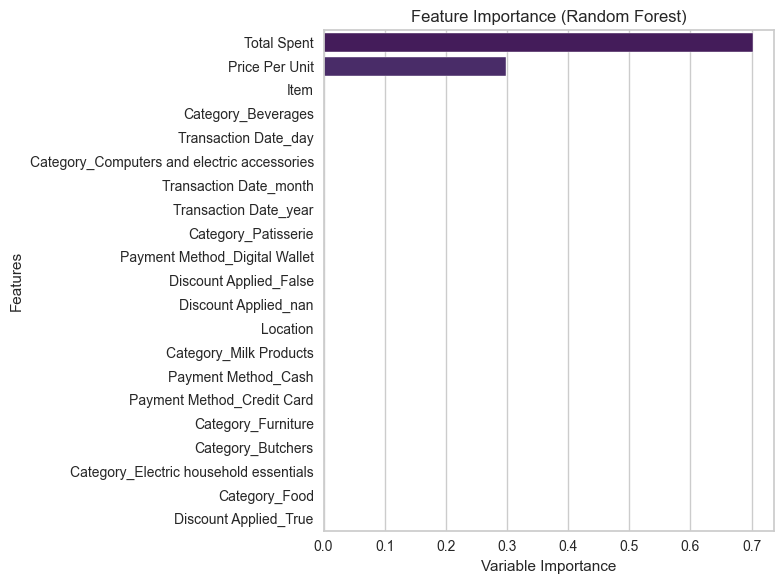

สร้างกราฟ Feature Importance แบบกำหนดเองสำเร็จ!


In [17]:
from pycaret.regression import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# STEP 1) โหลดข้อมูล
# ----------------------------------------------------------
data = pd.read_csv('data/retail_store_sales.csv')
print("ข้อมูลทั้งหมด:", data.shape)
print(data.head())

# ----------------------------------------------------------
# STEP 2) ทำความสะอาดข้อมูล (Data Cleaning) แบบง่าย ๆ
# ----------------------------------------------------------
# 2.1 ลบแถวที่ Quantity เป็น NaN
data.dropna(subset=['Quantity'], inplace=True)

# 2.2 บังคับคอลัมน์ numeric ให้เป็นตัวเลข
numeric_cols = ['Price Per Unit', 'Total Spent']
for col in numeric_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data.dropna(subset=[col], inplace=True)

# 2.3 บังคับคอลัมน์ที่เป็น categorical เป็น string
categorical_cols = [
    'Category',
    'Item',
    'Payment Method',
    'Location',
    'Discount Applied'
]
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype(str)

# 2.4 บังคับคอลัมน์วันที่ให้เป็น datetime
date_cols = ['Transaction Date']
for col in date_cols:
    if col in data.columns:
        try:
            data[col] = pd.to_datetime(data[col])
        except Exception as e:
            data[col] = data[col].astype(str)

print("ข้อมูลหลังทำความสะอาด:", data.shape)

# ----------------------------------------------------------
# STEP 3) ระบุฟีเจอร์ตามชนิด
# ----------------------------------------------------------
ignore_cols = ['Transaction ID', 'Customer ID']
numeric_cols = ['Price Per Unit', 'Total Spent']  # ฟีเจอร์ตัวเลข
categorical_cols = [
    'Category',
    'Item',
    'Payment Method',
    'Location',
    'Discount Applied'
]
date_cols = ['Transaction Date']

# ----------------------------------------------------------
# STEP 4) ตั้งค่า PyCaret
# ----------------------------------------------------------
exp1 = setup(
    data=data,
    target='Quantity',
    session_id=42,
    ignore_features=ignore_cols,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    date_features=date_cols,
    numeric_imputation='mean',
    categorical_imputation='mode',
    preprocess=True,
    use_gpu=False,
    html=False,
    verbose=False  # ถ้าอยากให้เห็น log ขณะทำงาน ใส่ True
)

# ----------------------------------------------------------
# STEP 5) สร้างโมเดลด้วย PyCaret (ตัวอย่าง Random Forest)
# ----------------------------------------------------------
rf_model = create_model('rf')

# ----------------------------------------------------------
# STEP 6) Finalize โมเดล เพื่อดึง feature_importances_
# ----------------------------------------------------------
final_rf = finalize_model(rf_model)

# ดึง DataFrame ของฟีเจอร์หลังทรานส์ฟอร์ม
X_train_transformed = get_config('X_train_transformed')
feature_names = X_train_transformed.columns
importances = final_rf.feature_importances_

# ----------------------------------------------------------
# STEP 7) รวมเป็น DataFrame และ Plot ด้วย Seaborn/Matplotlib
# ----------------------------------------------------------
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# ตัวอย่าง: ถ้าไม่อยากโชว์ฟีเจอร์ใด ๆ เช่น 'Unnamed: 0', 'ID' (ในกรณีอื่น ๆ)
# fi_df = fi_df[~fi_df['feature'].isin(['Unnamed: 0', 'ID'])]

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Variable Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("สร้างกราฟ Feature Importance แบบกำหนดเองสำเร็จ!")

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11362 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    11362 non-null  object        
 1   Customer ID       11362 non-null  object        
 2   Category          11362 non-null  object        
 3   Item              11362 non-null  object        
 4   Price Per Unit    11362 non-null  float64       
 5   Quantity          11362 non-null  float64       
 6   Total Spent       11362 non-null  float64       
 7   Payment Method    11362 non-null  object        
 8   Location          11362 non-null  object        
 9   Transaction Date  11362 non-null  datetime64[ns]
 10  Discount Applied  11362 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 1.3+ MB


In [22]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyCaret Classification
from pycaret.classification import setup, compare_models, finalize_model, plot_model, get_config

# --------------------------------------------------------
# 1) โหลดข้อมูลจากไฟล์ retail_store_sales.csv
# --------------------------------------------------------
data = pd.read_csv('data/retail_store_sales.csv')
print("ข้อมูลทั้งหมด:", data.shape)
print(data.head(), "\n")

# --------------------------------------------------------
# 2) Clean Data เบื้องต้น
# --------------------------------------------------------
# 2.1 ลบแถวที่ Discount Applied เป็น NaN
data.dropna(subset=['Discount Applied'], inplace=True)

# 2.2 สมมติ Discount Applied เป็น string
data['Discount Applied'] = data['Discount Applied'].astype(str)

# 2.3 บังคับคอลัมน์ numeric
numeric_cols = ['Price Per Unit', 'Quantity', 'Total Spent']
for col in numeric_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data.dropna(subset=[col], inplace=True)

# 2.4 แปลงคอลัมน์วันที่ (ถ้ามี)
date_col = 'Transaction Date'
if date_col in data.columns:
    try:
        data[date_col] = pd.to_datetime(data[date_col])
    except:
        data[date_col] = data[date_col].astype(str)

# --------------------------------------------------------
# 3) ระบุคอลัมน์
# --------------------------------------------------------
target_col = 'Discount Applied'
ignore_cols = ['Transaction ID', 'Customer ID']
categorical_cols = ['Category', 'Item', 'Payment Method', 'Location']
date_cols = ['Transaction Date']   # ถ้าไม่ต้องการใช้เป็น date จริง ๆ ให้ใส่เป็น [] ได้

# --------------------------------------------------------
# 4) ตั้งค่า PyCaret (Classification) - ปิดการสร้าง date_columns
# --------------------------------------------------------
clf1 = setup(
    data=data,
    target=target_col,
    session_id=1234,
    ignore_features=ignore_cols,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    date_features=date_cols,
    create_date_columns=False,   # ปิดเพื่อเลี่ยง error จาก date feature
    numeric_imputation='mean',
    categorical_imputation='mode',
    preprocess=True,
    use_gpu=False,
    html=False,
    verbose=True
)

# --------------------------------------------------------
# 5) เปรียบเทียบโมเดลหลาย ๆ ตัว
# --------------------------------------------------------
best_model = compare_models(sort='Recall')
print("\n=== โมเดลที่ Recall สูงสุด ===\n", best_model)

# --------------------------------------------------------
# 6) Finalize โมเดล
# --------------------------------------------------------
final_best = finalize_model(best_model)

# --------------------------------------------------------
# 7) Plot Feature Importance ของโมเดลที่ดีที่สุด
# --------------------------------------------------------
plot_model(final_best, plot='feature', save=False)
# ถ้าต้องการเซฟเป็น .png ให้ใช้ save=True

print("\n=== เสร็จสิ้นการเปรียบเทียบโมเดล และ Plot Feature Importance ===")

ข้อมูลทั้งหมด: (12575, 11)
  Transaction ID Customer ID       Category          Item  Price Per Unit  \
0    TXN_6867343     CUST_09     Patisserie   Item_10_PAT            18.5   
1    TXN_3731986     CUST_22  Milk Products  Item_17_MILK            29.0   
2    TXN_9303719     CUST_02       Butchers   Item_12_BUT            21.5   
3    TXN_9458126     CUST_06      Beverages   Item_16_BEV            27.5   
4    TXN_4575373     CUST_05           Food   Item_6_FOOD            12.5   

   Quantity  Total Spent  Payment Method Location Transaction Date  \
0      10.0        185.0  Digital Wallet   Online       2024-04-08   
1       9.0        261.0  Digital Wallet   Online       2023-07-23   
2       2.0         43.0     Credit Card   Online       2022-10-05   
3       9.0        247.5     Credit Card   Online       2022-05-07   
4       7.0         87.5  Digital Wallet   Online       2022-10-02   

  Discount Applied  
0             True  
1             True  
2            False  
3    

TypeError: 'bool' object is not iterable